In [43]:
using DataFrames, CSV
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots, GRUtils
using Distributions
using Gurobi, JuMP

In [44]:
# Data
data = Matrix(DataFrame(CSV.File("../data/demand.csv")));

# Constants
N = round(Int, (size(data)[1] - 2) / 2)    # number of trips
K = 3 ;                                    # number of shuttles

# Splitting the data into sublists
q = data[1:2*N+2, 4];
d = data[1:2*N+2, 5];
e = data[1:2*N+2, 7];
l = data[1:2*N+2, 8];

#### The cost matrix

We need to compute the cost matrix t[i,j]. For the moment, we know the cost matrix t[i,j] where i and j are origin-destination pairs. As a recall, we have selected 19 possible origins and 45 possible destinations. As our model here includes 99 trips, our current formulation gives: t[i,j] could be t[67,97] which of course leads to an error. Therefore, we should find a way to compute the cost matrix t[i,j] for each trip.

In [45]:
data

60×9 Matrix{Any}:
  0  42.3638  -71.0886   0  0.0  …  "Depot"
  1  42.3544  -71.1035   1  0.5     "Tang Hall"
  2  42.3588  -71.0999   1  0.5     "The Warehouse"
  3  42.3621  -71.0854   1  0.5     "Graduate Tower"
  4  42.3599  -71.102    1  0.5     "Sidney-Pacific"
  5  42.3588  -71.0999   2  0.5  …  "The Warehouse"
  6  42.3601  -71.098    1  0.5     "Edgerton House"
  7  42.36    -71.0884   1  0.5     "East Campus"
  8  42.3544  -71.1035   1  0.5     "Tang Hall"
  9  42.3553  -71.1006   1  0.5     "New House"
 10  42.3578  -71.0934   1  0.5  …  "Maseeh Hall"
 11  42.3544  -71.1035   1  0.5     "Tang Hall"
 12  42.3568  -71.0957   1  0.5     "Baker House"
  ⋮                              ⋱  
 19  42.3594  -71.0883  -1  0.5     "Walker Memorial"
 20  42.3601  -71.098   -1  0.5     "Edgerton House"
 21  42.355   -71.1055  -1  0.5  …  "W92 at Amesbury St"
 22  42.362   -71.0983  -2  0.5     "Random Hall"
 23  42.3574  -71.1004  -1  0.5     "Simmons Hall"
 24  42.3601  -71.098   -1  0.5

In [46]:
# Use this cost later to load costs from BingsMap. For now, we will simply use the euclidian distance as shown below.
driving_times = DataFrame(CSV.File("../data/OR_Full_Times.csv"));
origins_names = driving_times[:,1]
destinations_names = names(driving_times)[2:end];
driving_times = Matrix(driving_times)[:,2:end];

# Let's construct the matrix t[i,j]
t = zeros(2*N+2, 2*N+2)

# Create a dictionary
origin_dict = Dict(zip(origins_names,1:length(origins_names)));
destination_dict = Dict(zip(destinations_names,1:length(destinations_names)));


for i in 1:2*N+2
    for j in 1:2*N+2

        orr = data[i,9]
        des = data[j,9]

        # find the index of orr in origins_names
        # orr_index = findfirst(x -> x == orr, origins_names)
        # des_index = findfirst(x -> x == des, destinations_names)

        orr_index = origin_dict[orr]
        des_index = destination_dict[des]

        t[i,j] = driving_times[orr_index, des_index]
    end 
end 

c = t ; #let's consider in this initial model that the travel cost and the time and equivalent. 

### The model

In [47]:
model = Model(Gurobi.Optimizer)

V =  1:2*N+2                    # all vertices
P = 2:N+1                       # pick up vertices
D = N+2:2*N+1                   # drop off vertices
PUD = 2:2*N+1                   # all pick up and drop off vertices together (all vertices except depot)
P = 100                         # Penalty 


T = fill(100000, K)                # maximum duration of route k
L = 10000      
Q_max = 50                   # maximum time of a drive
Q = fill(Q_max, K)                # capacity of each car

# Variables
@variable(model, x[1:2*N+2, 1:2*N+2, 1:K] >= 0, Bin)   # x[i, j, k] = 1 if we go from node i to node j with vehicle k.
@variable(model, w[1:2*N+2, 1:K] >= 0, Int)            # w[i,k] load of vehicle k when arriving upon leaving vertex i
@variable(model, r[1:N] >= 0)                          # r[i,k] travel time of passenger i (Note that passenger i is identified by) the vertex i+1
@variable(model, u[1:2*N+2, 1:K] >= 0)                 # u[i,k] time as which the vertex i is served by vehicle k
@variable(model, a[1:2*N+2, 1:k] >= 0)                 # a[i,k] = max{u[i,k] - l[i], 0} (waiting time in excess for l[i] at vertex i for vehicle k)

#############  Constraints  #############

# only one car can bring passenger {i, i+N} to its final destination.
@constraint(model, [i in P], sum(sum(x[i, j, k] for j in V) for k = 1:K) == 1)

# each vehicle starts at the depot
@constraint(model, [k = 1:K], sum(x[1, j, k] for j in V) == 1)

# each vehicle ends at the depot
@constraint(model, [k = 1:K], sum(x[i, 2*N+2, k] for i in V) == 1)

# each passenger is picked and droped by the same car
@constraint(model, [i in P, k = 1:K], sum(x[i, j, k] for j in V) - sum(x[i+N, j, k] for j in V) == 0)

# vehicle k follows the edges sequentially
@constraint(model, [i in PUD, k = 1:K], sum(x[j, i, k] for j in V) - sum(x[i, j, k] for j in V) == 0)

# PREVIOUS the time served of vertex i
# @constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= (u[i, k] + d[i] + t[i, j]) * x[i, j, k])

# BIG M LINEARIZATION
M = zeros(2*N+2, 2*N+2)
for i in 1:2*N+2
    for j in 1:2*N+2
        M[i,j] = max(0, l[i] + d[i] + t[i,j] - e[j])
    end
end
@constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= u[i, k] + d[i] + t[i, j] - M[i,j]*(1-x[i, j, k]))


# updating the load of the vehicle
# @constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= (w[i, k] + q[j]) * x[i, j, k])

# BIG W LINEARIZATION
W = zeros(2*N+2, 2*N+2)
for i in 1:2*N+2
    for j in 1:2*N+2
        W[i,j] = min(Q_max, Q_max + q[i])
    end
end
@constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= w[i, k] + q[j] - W[i,j]*(1-x[i, j, k]))

# updating the travel time of passenger i
@constraint(model, [i in P, k = 1:K], r[i-1] == u[N+i, k] - (u[i, k] + d[i]))

# respecting the total length of a trip
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] >= 0) # NEW
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] <= T[k])

# respecting travel window of passenger i
@constraint(model, [i in V, k = 1:K], e[i] <= u[i,k])
#@constraint(model, [i in V, k = 1:K], u[i,k] <= l[i])
@constraint(model, [i in V, k = 1:K], a[i,k] >= u[i,k] - l[i])

# respecting travel window of passenger i
@constraint(model, [i in P], t[i,i+N] <= r[i-1])
@constraint(model, [i in P], r[i-1] <= L)

# respecting each car's capacity
@constraint(model, [i in V, k = 1:K], max(0, q[i]) <= w[i, k])
@constraint(model, [i in V, k = 1:K], w[i, k] <= min(Q[k], Q[k] + q[i]))


# objective
@objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V) + P * sum(sum(a[i,k] for k=1:K) for i in V));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [48]:
optimize!(model)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[arm])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 22767 rows, 11189 columns and 98989 nonzeros
Model fingerprint: 0xd71ef737
Variable types: 209 continuous, 10980 integer (10800 binary)
Coefficient statistics:
  Matrix range     [3e-02, 1e+03]
  Objective range  [2e-01, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+05]
Presolve removed 11710 rows and 3951 columns
Presolve time: 0.07s
Presolved: 11057 rows, 7238 columns, 53700 nonzeros
Variable types: 209 continuous, 7029 integer (6837 binary)

Root relaxation: objective 6.791640e+01, 1340 iterations, 0.07 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   67.91640    0  137          -   67.91640      -     -    0s
     0     0   68.82513    0  218          -   68

In [ ]:
x_values = value.(x)

20×20×3 Array{Float64, 3}:
[:, :, 1] =
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0   0.0
 -0.0   0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -0.0
 -0.0   0.0  -0.0   0.0   0.0   1.0     -0.0   0.0   0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0  -0.0   0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0  -0.0   0.0   0.0  …  -0.0   0.0   0.0   1.0   0.0  -0.0
 -0.0   0.0  -0.0  -0.0   0.0  -0.0     -0.0   1.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0   1.0   0.0   0.0     -0.0   0.0   0.0   0.0  -0.0  -0.0
 -0.0   0.0  -0.0   0.0   0.0  -0.0     -0.0  -0.0   0.0  -0.0   1.0  -0.0
  0.0   0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0  -0.0
 -0.0   0.0  -0.0   0.0   0.0  -0.0      1.0   0.0   0.0  -0.

In [ ]:
u_values = value.(u)

20×3 Matrix{Float64}:
  94.4197   49.7108   49.7108
  73.7275   73.7275   71.4
 153.155   158.355   158.355
 121.958   117.312   126.655
  81.5166   81.5166   81.5166
 125.365   125.365   125.365
  95.703   110.253   110.253
  91.5892   77.4833   77.4833
 121.458   116.339   116.339
 116.812   116.812   116.812
  78.4775   78.4775   76.15
 159.275   164.475   164.475
 141.665   137.019   146.362
  91.7443   91.7443   91.7443
 146.565   146.565   146.565
 105.703   120.253   120.253
 103.583    89.4776   89.4776
 131.458   126.339   126.339
 120.958   120.958   120.958
 173.142   173.142   173.142

In [ ]:
r_values = value.(r)

9-element Vector{Float64}:
  4.25
  5.620198142026737
 19.207268074567807
  9.727662753858397
 20.6999000000001
  9.5
 11.494262753858393
  9.5
  3.6457486821736325

In [ ]:
w_values = round.(Int, value.(w))

20×3 Matrix{Int64}:
  0  0  0
  1  1  1
  1  1  1
  2  1  1
  1  1  2
  3  1  1
  2  2  2
  1  1  1
  1  1  1
  1  1  1
  0  0  0
 49  0  0
  1  0  0
  0  0  0
  0  0  0
  0  0  0
  0  0  1
  2  0  0
  0  0  0
  0  0  0

In [ ]:
function plot_route(df, x_val, w_val, plot_size)
    
    # df: dataframe containing all the input data:
    #     column 1: Passenger ID
    #     column 2: PickUp/DropOff Pos_x
    #     column 3: PickUp/DropOff Pos_y
    #     column 4: load (number of passengers to embark)
    #     column 5: service duration (embark time)
    #     column 6: preferred pick up time
    #     column 7: lower bound of pick up time
    #     column 8: upper bound of pick up time

    # car_nbr: the vehicle number to plot

    # x_val: the values of x
    
    #constants 
    N = round(Int,(size(df)[1]-2)/2)

    cars_used = findall([sum(x_val[:,:,i]) for i=1:size(x_val)[3]] .> 2)
    
    println("Number of cars used: $(length(cars_used))")
    println("The car(s) used are(is): ", cars_used)

    plots = []

    for ii in 1:length(cars_used)

        car = cars_used[ii]

        p = Plots.plot(titlefont=font(20, "Computer Modern"), 
            title="Result for different shutle number: $car",  
            legend = :outertopright,
            format=:png)
        
        customers_deserved = findall(x_val[:, :, car] .== 1)
        pickup_deserved = [elem[1] for elem in customers_deserved] 
        pickup_deserved = [elem for elem in pickup_deserved if elem <= N+1]  

        dropoff_deserved = [elem[1] for elem in customers_deserved] 
        dropoff_deserved = [elem for elem in dropoff_deserved if elem > N+1] 

        # plot the depot
        Plots.scatter!(p, [df[1, 2]], [df[2*N+2, 3]], 
            color="black", 
            markersize=5, 
            labels="Depot", 
            size = (plot_size[1], plot_size[2]),
            )

        # plot all nodes
        for i in pickup_deserved
            pass_ID = round(Integer, df[i,1])

            Plots.scatter!(p, [df[i, 2]], [df[i, 3]],
                color="lightgreen", 
                xlabel="x", ylabel="y",
                labels="PickUp ID: $pass_ID - $(df[i,4]) passenger(s)",  
                annotations = (df[i, 2], df[i, 3], Plots.text("  Pick:$pass_ID", :left, pointsize=10)),
                format=:png,
                markersize=5)
        end

        # plot all nodes
        for i in dropoff_deserved
            pass_ID = round(Integer, df[i,1])

            Plots.scatter!(p, [df[i, 2]], [df[i, 3]],
                color="red", 
                xlabel="x", ylabel="y",
                labels="DropOff ID: $pass_ID - $(df[i,4]) passenger(s)",  
                annotations = (df[i, 2], df[i, 3], Plots.text("  Drop:$pass_ID", :left, pointsize=10)),
                format=:png,
                markersize=5)
        end




        colors = ["black", "red", "green", "blue", "pink"]
        vals = findall(x_val[:, :, car] .== 1)
        for elem in vals
            i, j = elem[1], elem[2]
            Plots.plot!(p, [df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
        end

        # plot the depot
        Plots.scatter!(p, [df[1, 2]], [df[2*N+2, 3]], 
            titlefont=font(20, "Computer Modern"), 
            color="black", 
            markersize=5, 
            labels="Depot", 
            format=:png)

        vals = findall(x_val[:, :, car] .== 1)
        # extract first element of cartesian index
        vals = [elem[1]-1 for elem in vals]        
        # get the values lower than N+1
        vals = [elem for elem in vals if elem < N+1]  
        # order the list vals
        vals = sort(vals)
        println("The shuttle $car served customers: ", vals)
        push!(plots, p)
    end
    return plots
end



plot_route (generic function with 1 method)

In [ ]:
x_values = round.(Int, value.(x))
w_values = round.(Int, value.(w))
plots = plot_route(data, x_values, w_values, [1100, 650]) ;

Number of cars used: 2
The car(s) used are(is): [1, 3]
The shuttle 1 served customers: [0, 3, 5, 6, 8, 9]
The shuttle 3 served customers: [0, 1, 2, 4, 7]


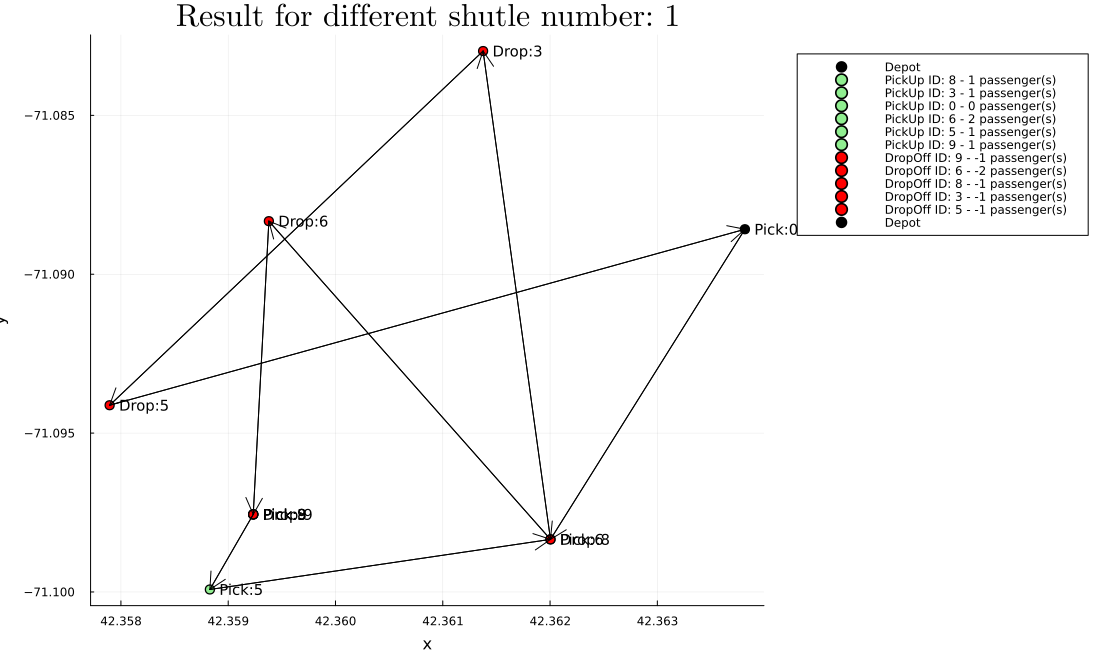

In [ ]:
plots[1]

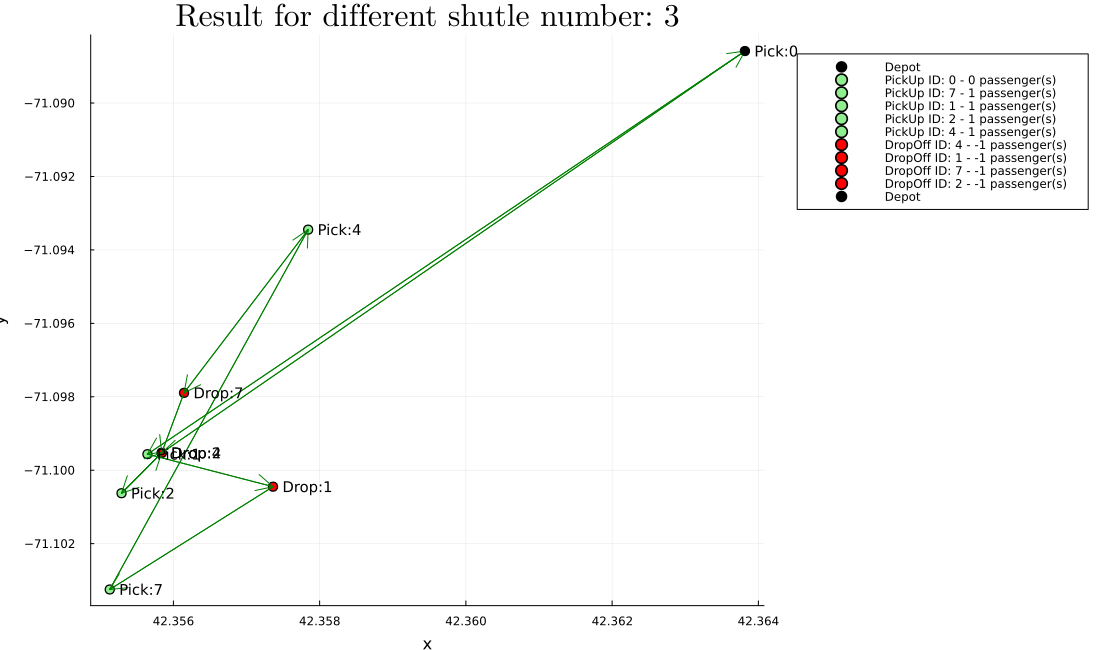

In [ ]:
plots[2]

In [ ]:
plots[3]

LoadError: BoundsError: attempt to access 2-element Vector{Any} at index [3]

In [ ]:
# get the indices all the elements equal to 1 in x_values
vals = [findall(x_values[:, :, i] .== 1)[1] for i=1:K]
vals

3-element Vector{CartesianIndex{2}}:
 CartesianIndex(11, 4)
 CartesianIndex(1, 9)
 CartesianIndex(25, 2)